In [1]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

np.random.seed(0)

In [2]:
experiment       = 'synth1'
abduction        = True
coeff_estimation = False

# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon, delta           = params.radius[experiment]
ll_num_envs, hl_num_envs = params.n_envs[experiment]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples, num_hlsamples  = params.n_samples[experiment]

# Load ground truth abstraction
Tau = mut.load_T(experiment)

In [3]:
Dll_obs  = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')
l        = len(Gll.nodes())

Dhl_obs  = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')
h        = len(Ghl.nodes())

omega    = mut.load_omega_map(experiment)

In [4]:
if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

In [5]:
if abduction == True:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
else:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

Experiment with different pertubations; i.e. different noise distributions

In [6]:
ll_loc = params.loc[experiment][0]
ll_scale = params.scale[experiment][0]
hl_loc = params.loc[experiment][1]
hl_scale = params.scale[experiment][1]
lenv = ops.MultivariateLaplace(ll_loc, ll_scale)
henv = ops.MultivariateLaplace(hl_loc, hl_scale)

U_ll_hat = lenv.sample(num_llsamples)
U_hl_hat = henv.sample(num_hlsamples)

In [7]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

# Optimisation

### 1. ERiCA optimization


In [8]:
epsilon, delta = 3,3 #3, 3 WORKS! BUT WHY?

eta_max = 0.001
eta_min = 0.001

max_iter = 100
num_steps_min = 5
num_steps_max = 5

robust_L = True 
robust_H = True

initialization = 'random'

tol = 1e-4

seed = 23

In [9]:
params_erica = {
                'U_L': U_ll_hat,
                'U_H': U_hl_hat,
                'L_models': LLmodels,
                'H_models': HLmodels,
                'omega': omega,
                'epsilon': epsilon,
                'delta': delta,
                'eta_min': eta_min,
                'eta_max': eta_max,
                'num_steps_min': num_steps_min,
                'num_steps_max': num_steps_max,
                'max_iter': max_iter,
                'tol': tol,
                'seed': seed,
                'robust_L': robust_L,
                'robust_H': robust_H,
                'initialization': initialization
            }

In [10]:
T_erica, Theta_erica, Phi_erica = oput.run_empirical_erica_optimization(**params_erica)

100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


In [11]:
empirical_boundary_params = {'Theta': (Theta_erica, epsilon), 'Phi': (Phi_erica, delta)}


joblib.dump(empirical_boundary_params, f"data/{experiment}/empirical_boundary_params.pkl")

['data/synth1/empirical_boundary_params.pkl']

### 2. ENRiCO optimization

In [12]:

T_enrico, Theta_enrico, Phi_enrico = oput.run_empirical_erica_optimization(**{**params_erica, 'robust_L': False, 'robust_H': False})

100%|██████████| 100/100 [00:01<00:00, 93.44it/s]


## 3. Random Abstraction

In [13]:
n_samples = 10
condition_nums_random = []
best_T = None
min_condition = float('inf')
max_condition = 0
for i in range(n_samples):
    T = np.random.randn(h, l)
    condition_num = evut.condition_number(T)
    condition_nums_random.append(condition_num)
    
    # Track the matrix with minimum condition number
    if condition_num < min_condition:
        min_condition = condition_num
        T_random = T.copy()

    if condition_num > max_condition:
        max_condition = condition_num
        T_random2 = T.copy()

## 4. Randomized Smoothing

In [14]:
params_smooth = {
                'U_L': U_ll_hat,
                'U_H': U_hl_hat,
                'L_models': LLmodels,
                'H_models': HLmodels,
                'omega': omega,
                'eta_min': eta_min,
                'num_steps_min': num_steps_min,
                'max_iter': max_iter,
                'tol': tol,
                'seed': seed,
                'noise_sigma': 0.1,
                'num_noise_samples': 10
                }

In [15]:
T_smooth = oput.run_empirical_smooth_optimization(**params_smooth)

100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


## Save the results

In [16]:
joblib.dump(T_erica, f"data/{experiment}/T_erica.pkl")
joblib.dump(T_enrico, f"data/{experiment}/T_enrico.pkl")
joblib.dump(T_random, f"data/{experiment}/T_random.pkl")
joblib.dump(T_random2, f"data/{experiment}/T_random2.pkl")
joblib.dump(T_smooth, f"data/{experiment}/T_smooth.pkl")
joblib.dump(Tau, f"data/{experiment}/Tau.pkl")

['data/synth1/Tau.pkl']

# Evaluation

In [17]:
methods = {
            'T_erica': T_erica, 'T_enrico': T_enrico,
            'T_random': T_random, 'T_random2': T_random2,
            'T_smooth': T_smooth, 'Tau': Tau
          }

data           = mut.load_samples(experiment)

# Load data
#data = mut.load_samples(experiment)

# Generate data
data = evut.generate_empirical_data(LLmodels, HLmodels, omega, U_ll_hat, U_hl_hat)

### Condition number comparison

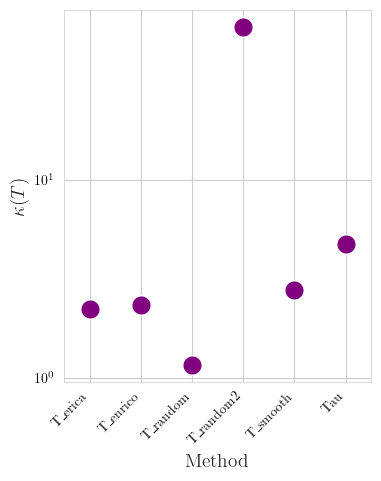

In [18]:
condition_nums = {}
for name, abstraction in methods.items():
    condition_nums[name] = evut.condition_number(abstraction)

evut.plot_condition_nums(condition_nums)

### Abstraction error comparison

In [29]:
add_pertL          = True
add_pertH          = True
pert_typeL         = 'constraint_set'
pert_typeH         = 'constraint_set'

test_observ        = False
test_interv        = True#False

lin_contaminationL = False
lin_contaminationH = False
cont_type          = 'huber'
cont_fracL         = .9
cont_fracH         = .6

metric             = 'fro'
num_iter           = 10 

In [30]:
if test_observ and test_interv:
    test_data = data

elif test_observ:
    test_data = {None: data[None]}

elif test_interv:
    test_data = {k: v for k, v in data.items() if k is not None}

random_normal random_normal


100%|██████████| 10/10 [00:00<00:00, 17.54it/s]


Average e(τ) for T_erica: 1085.596 ± 0.850

Average e(τ) for T_enrico: 1418.366 ± 1.168

Average e(τ) for T_random: 2046.231 ± 0.945

Average e(τ) for T_random2: 1537.263 ± 1.633

Average e(τ) for T_smooth: 1062.693 ± 0.866

Average e(τ) for Tau: 2165.775 ± 2.071



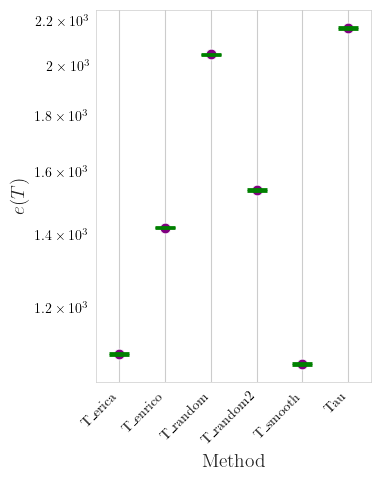

In [32]:
#for (pert_typeL, pert_typeH) in product(['random_normal', 'random_uniform', 'constraint_set', 'boundary'], ['random_normal', 'random_uniform', 'constraint_set', 'boundary']):
for (pert_typeL, pert_typeH) in product(['random_normal'], ['random_normal']):

    print(pert_typeL, pert_typeH)
    abstraction_error = {name: [] for name in methods.keys()}
    k                 = list(test_data.keys())[0]

    # Outer loop: number of noise sampling iterations
    for iter_num in tqdm(range(num_iter)): # desc="Noise sampling iterations"

        pert_L = evut.generate_pertubation(test_data[k][0], pert_typeL, 'Theta', experiment)
        pert_H = evut.generate_pertubation(test_data[k][1], pert_typeH, 'Phi', experiment)

        for name, T in methods.items():

            total = 0
            for iota in test_data.keys():
                base, abst = test_data[iota]

                if add_pertL:
                    base = base + pert_L 
                if add_pertH:
                    abst = abst + pert_H 
                    
                if lin_contaminationL:
                    base  = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
                if lin_contaminationH:
                    abst  = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
                    
                base_norm = base / np.linalg.norm(base, 'fro')
                abst_norm = abst / np.linalg.norm(abst, 'fro')
                # Apply method and compute distance
                tau_base = base @ T.T
                dist = evut.compute_empirical_distance(tau_base, abst, metric)
                    
                total   += dist
                
            iter_avg = total / len(Ill)
            abstraction_error[name].append(iter_avg)
        
        final_abstraction_error = {}
    for name in methods:
        mean_e = np.mean(abstraction_error[name])
        std_e = np.std(abstraction_error[name])
        final_abstraction_error[name] = (mean_e, std_e * 1.96)
        print(f"Average e(τ) for {name}: {mean_e:.3f} ± {std_e:.3f}\n")

    evut.plot_abstraction_error(final_abstraction_error)
    print( )

### Abstraction error vs Condition number

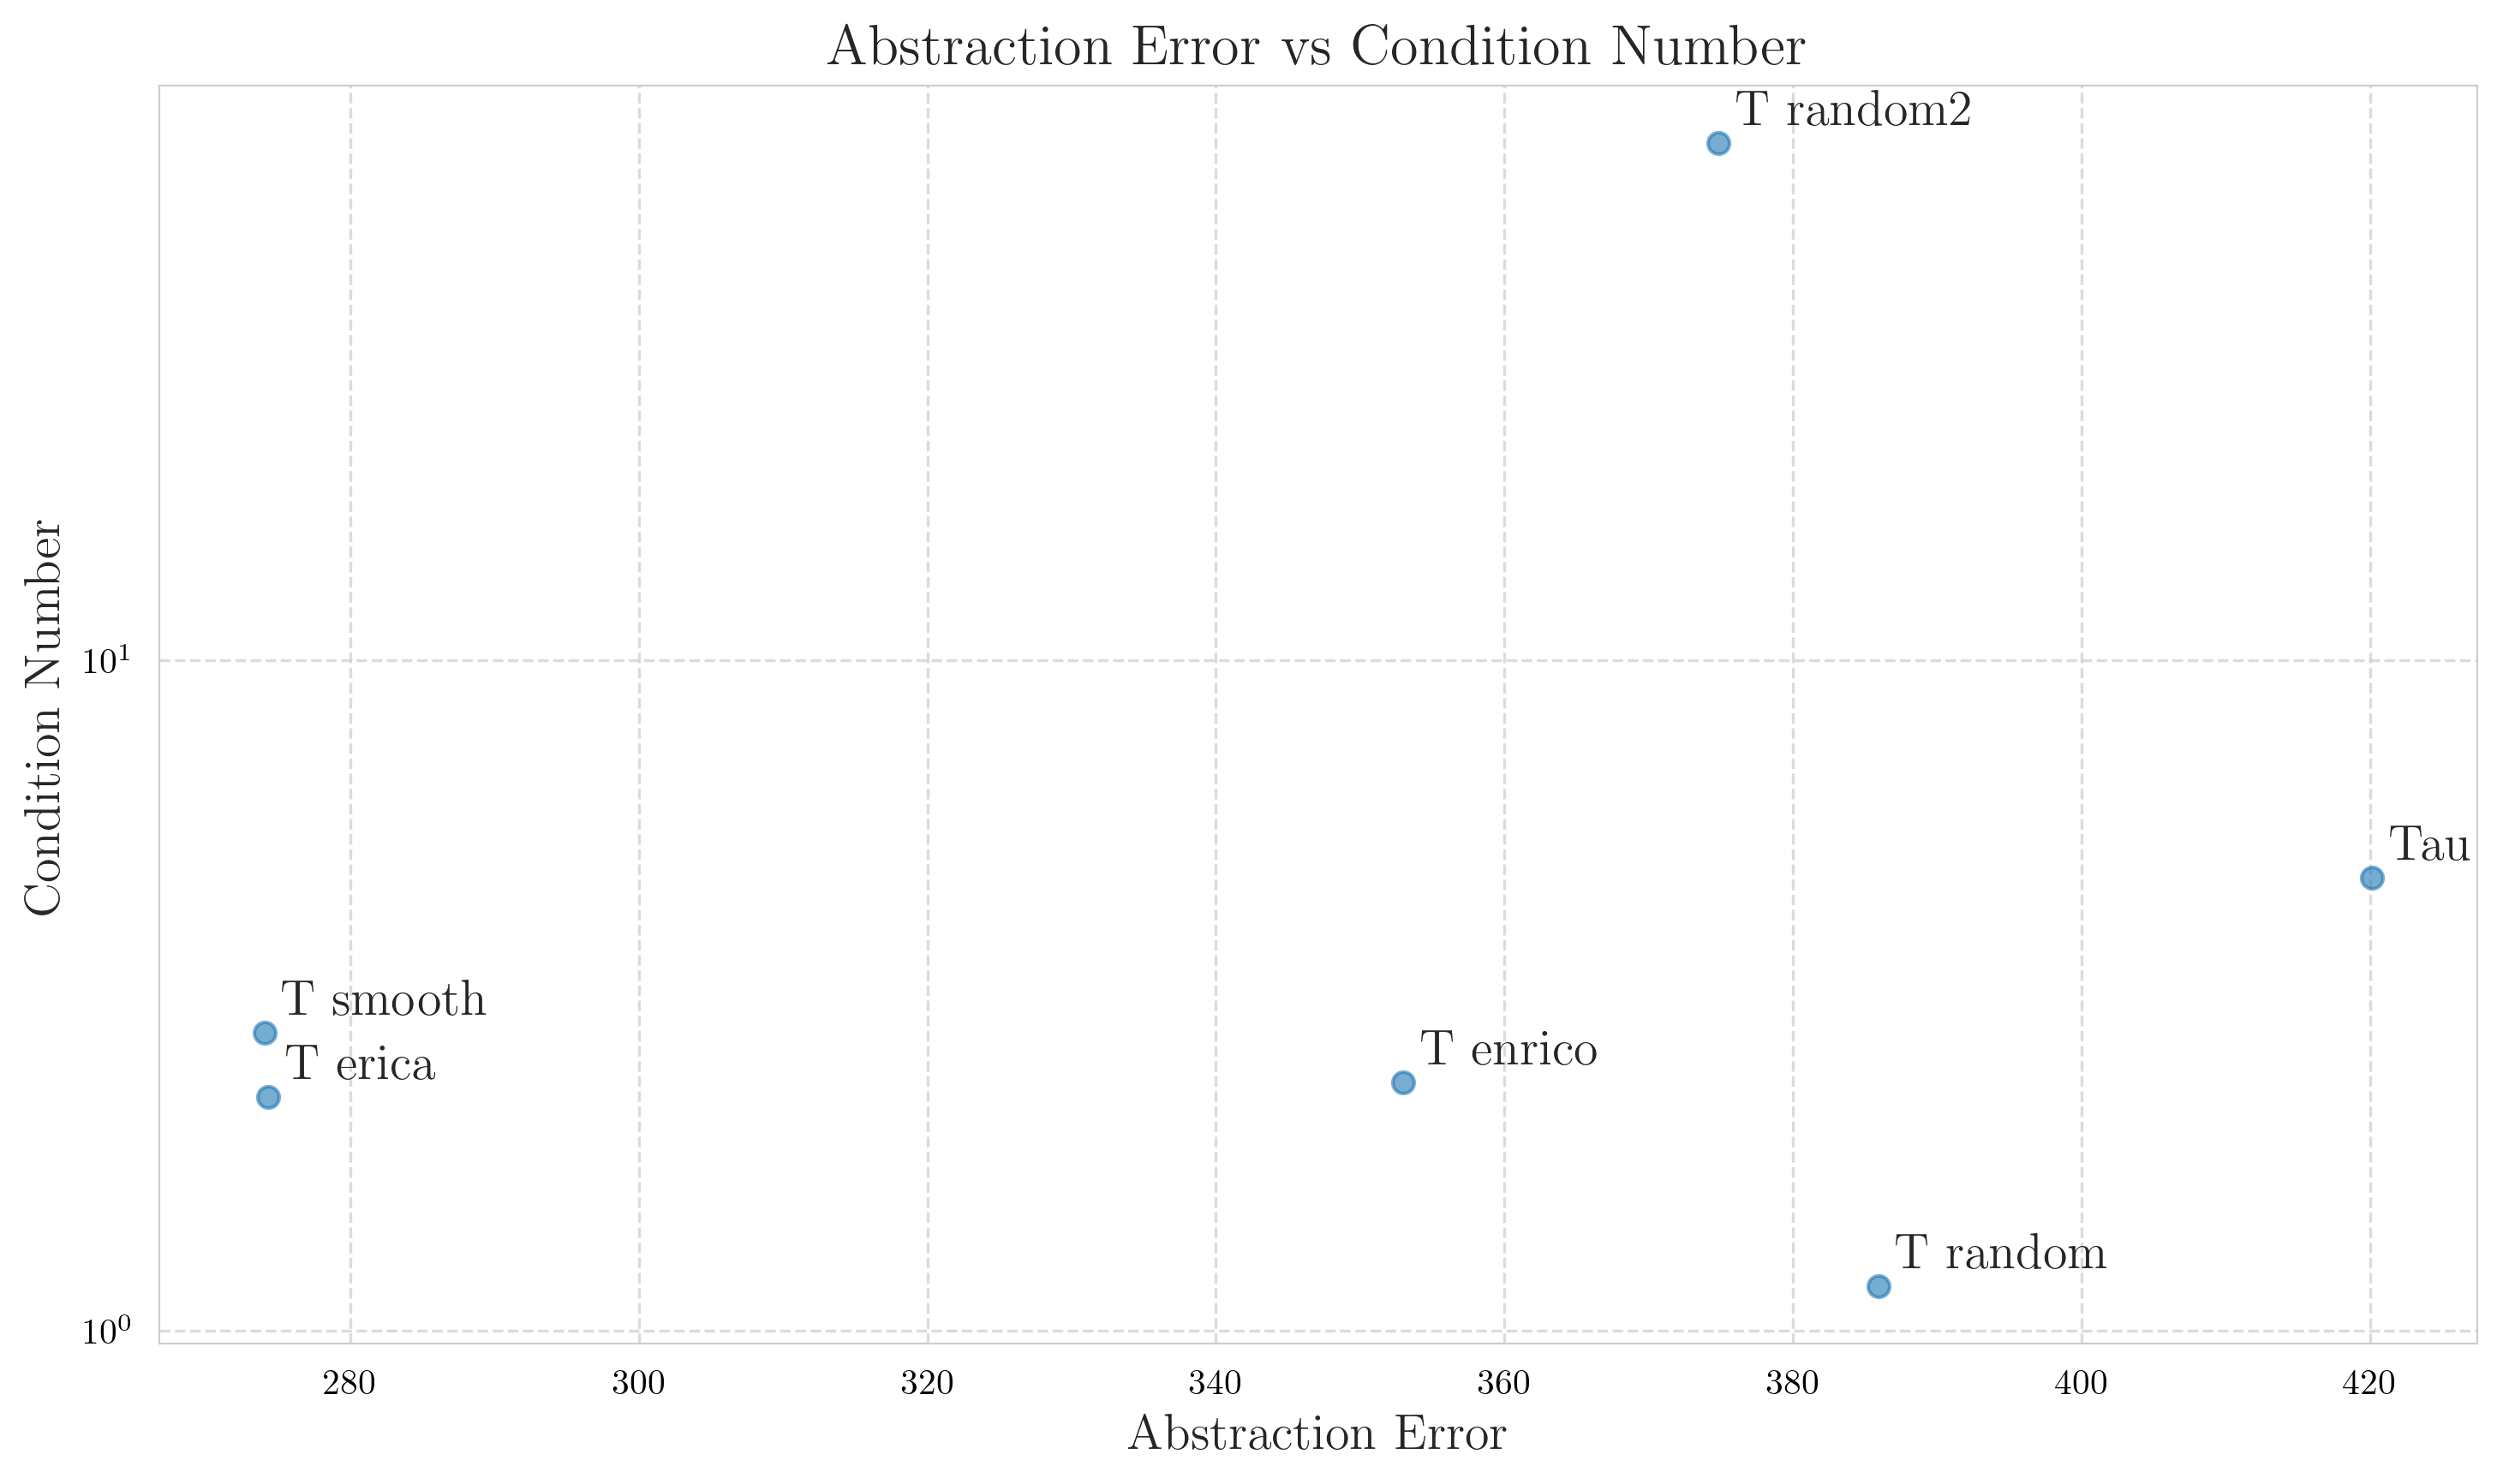


Method		Abstraction Error	Condition Number
--------------------------------------------------
T_erica            274.286		     2.228
T_enrico           352.961		     2.345
T_random           385.920		     1.164
T_random2          374.825		    59.160
T_smooth           274.030		     2.780
Tau                420.170		     4.739


In [22]:
# Create lists to store the values
methods_list = list(methods.keys())
#abstraction_errors = [final_abstraction_error[method][0] for method in methods_list]  # Get mean errors
abstraction_errors = [min(abstraction_error[method]) for method in methods_list]
condition_numbers = [condition_nums[method] for method in methods_list]

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Plot points
plt.scatter(abstraction_errors, condition_numbers, alpha=0.6)

# Add labels for each point
for i, method in enumerate(methods_list):
    plt.annotate(method.replace('_', ' '), 
                (abstraction_errors[i], condition_numbers[i]),
                xytext=(5, 5), textcoords='offset points')

# Add labels and title
plt.xlabel('Abstraction Error')
plt.ylabel('Condition Number')
plt.title('Abstraction Error vs Condition Number')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Optional: Set log scale for y-axis if condition numbers vary widely
plt.yscale('log')

# Adjust layout to prevent label clipping
plt.tight_layout()

plt.show()

# Optionally, print the values in a table format
print("\nMethod\t\tAbstraction Error\tCondition Number")
print("-" * 50)
for method in methods_list:
    print(f"{method:<15} {final_abstraction_error[method][0]:>10.3f}\t\t{condition_nums[method]:>10.3f}")